# Model Training

## 1. Load Preprocessed Dataset
- Load the preprocessed train, validation, and test datasets.

In [40]:
import sys
import os

# Add the parent directory to the system path
sys.path.append(os.path.abspath(os.path.join('..')))

import tensorflow as tf
from src.utils import dataset_utils as du
from src.utils import visualization_utils as vu


# prevent TensorFlow from allocating all the GPU memory at the start
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)


# Read data from localhost
base_path = "/tf/projects/mnist-keras-ann-classifier/notebooks"
x_train, y_train, x_test, y_test = du.load_dataset(base_path, format='pickle')

# Ensure data shapes are correct
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

# Check a few samples of the labels
print("Sample labels:", y_train[:10])

# Ensure labels are integer type
y_train = y_train.astype(int)
y_test = y_test.astype(int)


Dataset loaded from /tf/projects/mnist-keras-ann-classifier/notebooks
x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)
Sample labels: [5 0 4 1 9 2 1 3 1 4]



## 2. Define Model
- Define the architecture using TensorFlow/Keras.

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

def mnist_model():
    model = Sequential([
        Input(shape=(28, 28)),
        Flatten(),
        Dense(units=128, activation='relu'),
        Dropout(0.15),
        Dense(units=10, activation='softmax')
    ])
    return model


model = mnist_model()
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_9 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)


## 3. Compile Model
- Compile the model with an appropriate optimizer, loss function, and metrics.

In [50]:
model.compile(
    optimizer=Adam(),
    loss=sparse_categorical_crossentropy,
    metrics=[SparseCategoricalAccuracy()]
)


## 4. Train Model
- Define necessary callbacks 
- Train the model on the training dataset.
- Validate the model on the validation dataset.

In [51]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

# Define the callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.001
)

tensorboard = TensorBoard(
    log_dir='./logs',
    histogram_freq=1,
    write_graph=True,
    write_images=True
)

# Fit the model with the callbacks
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=512,
    epochs=25,
    verbose=1,
    validation_split=0.2,
    shuffle=True,
    validation_batch_size=512,
    callbacks=[early_stopping, model_checkpoint, reduce_lr, tensorboard]
)


Epoch 1/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 112ms/step - loss: 31.6575 - sparse_categorical_accuracy: 0.6127 - val_loss: 1.4293 - val_sparse_categorical_accuracy: 0.8445 - learning_rate: 0.0010
Epoch 2/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 1.6316 - sparse_categorical_accuracy: 0.7939 - val_loss: 0.8582 - val_sparse_categorical_accuracy: 0.8484 - learning_rate: 0.0010
Epoch 3/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.9203 - sparse_categorical_accuracy: 0.8194 - val_loss: 0.6769 - val_sparse_categorical_accuracy: 0.8729 - learning_rate: 0.0010
Epoch 4/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.6900 - sparse_categorical_accuracy: 0.8466 - val_loss: 0.5963 - val_sparse_categorical_accuracy: 0.8937 - learning_rate: 0.0010
Epoch 5/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.5884 - sparse_categorical_accuracy: 0.8700 - val_loss: 0.5325 - val_sparse_categorical_accuracy: 0.9024 - learning_rate: 0.0010
Epoch 6/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step -


## 5. Evaluate Model

- Evaluate the model on the test dataset.


In [52]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(x=x_test, y=y_test, batch_size=512)
print(f"Test accuracy: {test_accuracy:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.4169 - sparse_categorical_accuracy: 0.9411
Test accuracy: 0.9505


In [54]:
import tensorflow as tf

# Create a dataset from the test data
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(512)

# Evaluate each batch
for batch, (x_batch, y_batch) in enumerate(test_dataset):
    loss, accuracy = model.evaluate(x_batch, y_batch, verbose=0)
    print(f"Batch {batch + 1}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}")

# Finally, evaluate on the whole test dataset
test_loss, test_accuracy = model.evaluate(x=x_test, y=y_test, batch_size=512)
print(f"Overall Test Loss: {test_loss:.4f}, Overall Test Accuracy: {test_accuracy:.4f}")


Batch 1: Loss = 0.2835, Accuracy = 0.9590
Batch 2: Loss = 0.6037, Accuracy = 0.9375
Batch 3: Loss = 0.6084, Accuracy = 0.9004
Batch 4: Loss = 0.4979, Accuracy = 0.9297
Batch 5: Loss = 0.5037, Accuracy = 0.9316
Batch 6: Loss = 0.5093, Accuracy = 0.9277
Batch 7: Loss = 0.5191, Accuracy = 0.9316
Batch 8: Loss = 0.4631, Accuracy = 0.9238
Batch 9: Loss = 0.3809, Accuracy = 0.9336
Batch 10: Loss = 0.2748, Accuracy = 0.9570
Batch 11: Loss = 0.0924, Accuracy = 0.9824
Batch 12: Loss = 0.2774, Accuracy = 0.9473
Batch 13: Loss = 0.4132, Accuracy = 0.9629
Batch 14: Loss = 0.1184, Accuracy = 0.9824
Batch 15: Loss = 0.1269, Accuracy = 0.9805
Batch 16: Loss = 0.1942, Accuracy = 0.9551
Batch 17: Loss = 0.0702, Accuracy = 0.9844
Batch 18: Loss = 0.0690, Accuracy = 0.9766
Batch 19: Loss = 0.2028, Accuracy = 0.9746
Batch 20: Loss = 0.4602, Accuracy = 0.9154
 1/20 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.2835 - sparse_categorical_accuracy: 0.9590

2024-07-19 05:07:35.403846: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4169 - sparse_categorical_accuracy: 0.9411
Overall Test Loss: 0.3304, Overall Test Accuracy: 0.9505



## 6. Visualize Training History
- Plot training and validation loss and accuracy over epochs.

,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy,learning_rate
0,12.214315,0.741771,1.429281,0.844500,0.001
1,1.380326,0.797125,0.858217,0.848417,0.001
2,0.866713,0.827062,0.676909,0.872917,0.001
3,0.678725,0.850833,0.596314,0.893667,0.001
4,0.566854,0.872563,0.532489,0.902417,0.001
5,0.470850,0.887521,0.488959,0.908917,0.001
6,0.414181,0.897271,0.477757,0.916250,0.001
7,0.368063,0.904667,0.427645,0.921833,0.001
8,0.326784,0.914187,0.430630,0.925417,0.001
9,0.296349,0.919000,0.411323,0.930167,0.001


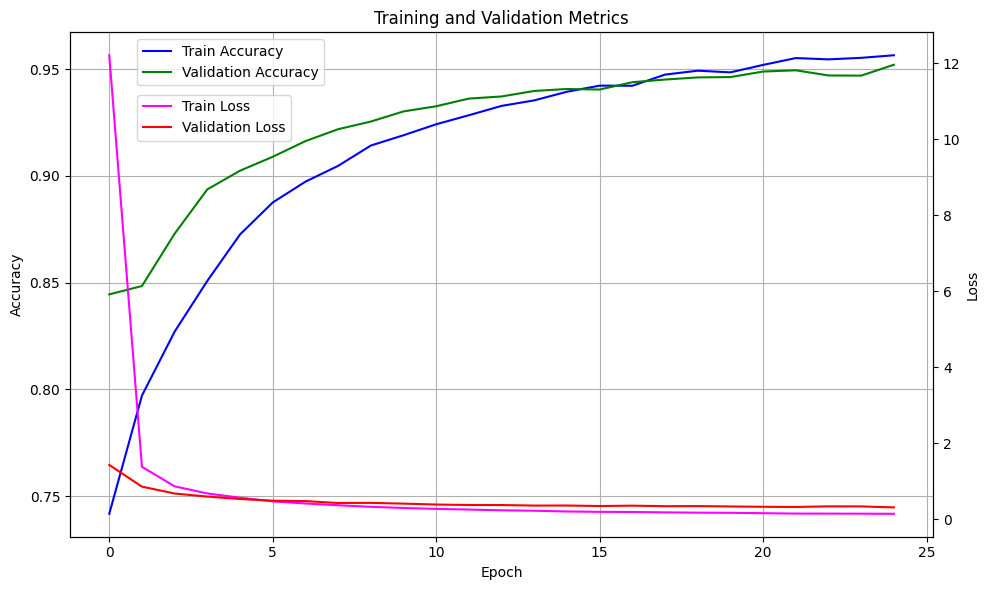

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Convert the history dictionary to a DataFrame
df = pd.DataFrame(data=history.history)
display(df)

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot training and validation accuracy on the primary y-axis
ax1.plot(df['sparse_categorical_accuracy'], label='Train Accuracy', color='blue')
ax1.plot(df['val_sparse_categorical_accuracy'], label='Validation Accuracy', color='green')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='upper left', bbox_to_anchor=(0.07, 1))

# Create a second y-axis to plot training and validation loss
ax2 = ax1.twinx()
ax2.plot(df['loss'], label='Train Loss', color='magenta')
ax2.plot(df['val_loss'], label='Validation Loss', color='red')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper left', bbox_to_anchor=(0.07, 0.89))

# Add grid and title
ax1.grid(True, 'both')
plt.title('Training and Validation Metrics')

# Adjust layout to prevent overlap
fig.tight_layout()

# Show the plot
plt.show()



## 7. Save Model
- Save the trained model for future use.


In [61]:
# Save the model in the native Keras format
model.save('/tf/projects/mnist-keras-ann-classifier/notebooks/mnist_model_batch_512.keras')